## Tessearct collision
1. The module uses class loading to load collision managers from bullet and fcl. The discrete and continuous collision checkers loaded as plugins are as follow:
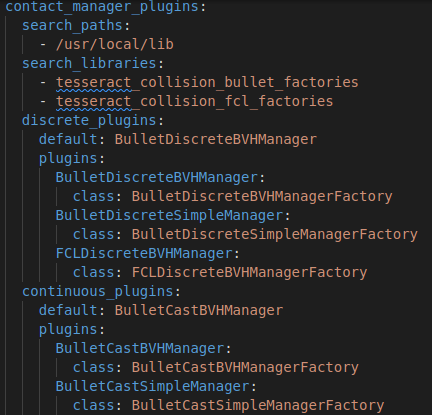
2. These checkers are derived from abstract base classes `DiscreteContactManager` and `ContinuousContactManager` for discrete and continous collisions respectively. These two abstract classes act as the API for the plugin loader. Collision tests are run using the `contactTest` function

### Bullet discrete bvh manager
#### TesseractCollisionConfiguration
1. The `TesseractCollisionConfiguration` inherits from the default `btDefaultCollisionConfiguration`. The former replaces several collision checking functions, namely `m_compoundCreateFunc`, `m_compoundCompoundCreateFunc`, `m_swappedCompoundCreateFunc` and `m_convexConvexCreateFunc`. Note that `m_compoundCreateFunc` and `m_swappedCompoundCreateFunc` are similar except for the order of the collision objects. For `m_compoundCreateFunc`, the first object is the compound collision shape while `m_swappedCompoundCreateFunc` stores the compound collision shape as the second object.
2. These functions are replaced by Tesseract algorithms that are derived classes of `btActivatingCollisionAlgorithm`

#### BulletDiscreteBVHManager
1. The manager is initialized with bullet's `dispatcher_` and `boardphase_` interfaces. The `dispatcher_` is initialized as `dispatcher_->registerCollisionCreateFunc(BOX_SHAPE_PROXYTYPE,BOX_SHAPE_PROXYTYPE,coll_config_.getCollisionAlgorithmCreateFunc(CONVEX_SHAPE_PROXYTYPE, CONVEX_SHAPE_PROXYTYPE))`, i.e. the boardphase algorithm will use boxes as the proxies and a singular convex-convex collision checking algorithm is loaded.
2. `dispatcher_` is further customized to disable `CD_USE_RELATIVE_CONTACT_BREAKING_THRESHOLD` in order to improved performance. See comment in bullet: *//optional relative contact breaking threshold, turned on by default (use setDispatcherFlags to switch off feature for improved performance)*
3. `boardphase_` is customized to filter collision objects before the broadphase check. This is done by overriding the `needBroadphaseCollision` function with a call to `needsCollisionCheck` where the allowable collision matrix (defined through `IsContactAllowedFn`) is used.
4. Finally, the collision margin is defaulted to 0

#### contactTest
1. The `contactTest` function first puts the **request** and **result** into `contact_test_data_` before the collision check. `contact_test_data_.done` is used as a flag to monitor when all the contacts have been processed.
2. Next `btOverlappingPairCache* pairCache = broadphase_->getOverlappingPairCache()` gets a local pointer to the current overlapped pairs (that indicate potential collision) from the sweep and prune algorithm. This is followed by an update of the algorithm through `broadphase_->calculateOverlappingPairs(dispatcher_.get());`
3. `DiscreteBroadphaseContactResultCallback` is then created to record contact points recorded from broad phase checks. This is combined into `collisionCallback` which is an instance of `TesseractCollisionPairCallback` that inherits from `btOverlapCallback`.
4. Taking this in, the processing of the overlapping pairs happen at `pairCache->processAllOverlappingPairs(&collisionCallback, dispatcher_.get())`

#### processAllOverlappingPairs
1. The `pairCache` is specialized as a `btHashedOverlappingPairCache` object. The pairs are processed thorugh the `collisionCallback`'s `processOverlap` function. The processed pairs are subsequently removed.
2. 